In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pyro
import torch
import pyro.distributions as dist
import torch.nn as nn

from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS
from pyro.optim import ClippedAdam, Adam
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive
from typing import Dict, Tuple, List
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from tqdm.autonotebook import tqdm
from pyro.nn import PyroModule, PyroSample

In [2]:
data_path = '../data/raw/raw2'

## Data Preparation

Read the raw data

In [3]:
failures_path = os.path.join(data_path, 'PdM_failures.csv')
errors_path = os.path.join(data_path, 'PdM_errors.csv')
machines_path = os.path.join(data_path, 'PdM_machines.csv')
maint_path = os.path.join(data_path, 'PdM_maint.csv')
telemetry_path = os.path.join(data_path, 'PdM_telemetry.csv')

In [4]:
failures_df = pd.read_csv(failures_path)
errors_df = pd.read_csv(errors_path)
machines_df = pd.read_csv(machines_path)
maint_df = pd.read_csv(maint_path)
telemetry_df = pd.read_csv(telemetry_path)

Transform `datetime` column

In [ ]:
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'], format="%Y-%m-%d %H:%M:%S")
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'], format="%Y-%m-%d %H:%M:%S")
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'], format="%Y-%m-%d %H:%M:%S")

#### Dataset transformation

Maintenance data

In [ ]:
#create a function that takes a column and returns its mean and std of a moving window of 3 hours
def rolling_mean_std(col,window):
    return col.rolling(window).agg(['mean', 'std'])

#apply the function to the telemetry data
def telem_(telemetry,column,window):
    telemetry[[column+'mean_'+str(window)+'h', column+'sd_'+str(window)+'h']] = telemetry.groupby('machineID')[column].apply(rolling_mean_std,window)
    return telemetry

def lifespan(replacement_event_df: DataFrame)->DataFrame:
    
    '''
    Receives a dataframe with timestamp and columns that signify when a component is replaced, with 1.
    Returns a dataframe with the days since the last replacement for the component
    '''
    
    comp_rep=replacement_event_df.copy()
    points = comp_rep['machineID'].unique()
    final=pd.DataFrame()
    
    for i in tqdm(points, desc='Machine'):
        df = comp_rep[(comp_rep['machineID']==i)][['datetime','machineID','comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']]
        for comp in ['comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']:
            
            # keep the last part of component name
            life = comp[5:]
            
            #apply function in each row of df[life] column where if row[comp]==1 then value=0.041667 else 0
            df[life+'_maint'] = df.apply(lambda row: 0 if row[comp]==1 else 0.041667, axis=1)

            df_maint = df[life+'_maint'] != 0
            df[life+'_maint'] = df_maint.cumsum()-df_maint.cumsum().where(~df_maint).ffill().fillna(0).astype(int)
            df[life+'_maint'] = df[life+'_maint'].apply(lambda x: x*0.041667)
            
            
        final=pd.concat([final,df],axis=0)
        final=final[['datetime', 'machineID', 'comp1_maint', 'comp2_maint', 'comp3_maint', 'comp4_maint']]
        
    return final.copy()

In [ ]:
telemetry_df = telem_(telemetry_df,'volt',3)
telemetry_df = telem_(telemetry_df,'rotate',3)
telemetry_df = telem_(telemetry_df,'pressure',3)
telemetry_df = telem_(telemetry_df,'vibration',3)
telemetry_df = telem_(telemetry_df,'volt',24)
telemetry_df = telem_(telemetry_df,'rotate',24)
telemetry_df = telem_(telemetry_df,'pressure',24)
telemetry_df = telem_(telemetry_df,'vibration',24)
#telemetry_df=telemetry_df.drop(['volt','rotate','pressure','vibration'],axis=1)
telemetry_df=telemetry_df.dropna()

In [ ]:
maint_transf_df = pd.get_dummies(maint_df, columns=['comp'])
maint_transf_df = telemetry_df.merge(maint_transf_df, on=['datetime', 'machineID'], how='left')
maint_transf_df= maint_transf_df[['datetime', 'machineID', 'comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']]
maint_transf_df = maint_transf_df.fillna(0)

In [ ]:
maintenance_df = lifespan(maint_transf_df)

In [ ]:
maintenance_df.head()

#### Merging the rest of the datasets

In [ ]:
#fget dummies for errorID
error_count = pd.get_dummies(errors_df, columns=['errorID'])
error_count.rename(columns={'errorID_error5':'error5count'}, inplace=True)
error_count.rename(columns={'errorID_error4':'error4count'}, inplace=True)
error_count.rename(columns={'errorID_error3':'error3count'}, inplace=True)
error_count.rename(columns={'errorID_error2':'error2count'}, inplace=True)
error_count.rename(columns={'errorID_error1':'error1count'}, inplace=True)

features = telemetry_df.merge(error_count, on=['datetime', 'machineID'], how='left')

# Propagate the error information per error type
features[['error1count','error2count','error3count','error4count','error5count']] = features[['error1count','error2count','error3count','error4count','error5count']].fillna(method='ffill')
# Fill the iinital error count with 0
features = features.fillna(0)

# turn "model" variable into dummy variables
machines_df['model'] = machines_df['model'].astype('category')
machines_dummy = pd.get_dummies(machines_df, drop_first=False)

# Add the machine metadata information
features = features.merge(machines_df[['machineID','model']], on=['machineID'], how='left')
features = features.merge(machines_dummy, on=['machineID'], how='left')
features = features.merge(maintenance_df, on=['datetime', 'machineID'], how='left')

Merge the failures dataset

In [ ]:
fails = pd.get_dummies(failures_df,columns=['failure'])
#fails.rename(columns={'failure_comp1':'comp1'}, inplace=True)
#fails.rename(columns={'failure_comp2':'comp2'}, inplace=True)
#fails.rename(columns={'failure_comp3':'comp3'}, inplace=True)
#fails.rename(columns={'failure_comp4':'comp4'}, inplace=True)

In [ ]:
def lifespan_fails(comp_rep0):
    comp_rep=comp_rep0.copy()
    points = comp_rep['machineID'].unique()
    final=pd.DataFrame()

    for i in points:
        df = comp_rep[(comp_rep['machineID']==i)][['datetime','machineID','failure_comp1','failure_comp2','failure_comp3','failure_comp4']]
        for comp in ['failure_comp1','failure_comp2','failure_comp3','failure_comp4']:
            life=comp.split('_')[1]+'_life'
#             prob=comp+'_prob'
#             probkm=comp+'_probkm'
            df[life] = df.apply(lambda row: row['datetime'] if row[comp]==0 else np.nan, axis=1)
            df[df[life].isna()==False].index
            df[life].fillna(method='backfill', inplace=True)
            df[life] = pd.to_datetime(df[life]) - df['datetime']
            df[life] = df[life].apply(lambda row: row.total_seconds()/86400)
#             df[prob] = df[life]/(df[life]+df[comp])
#             df[prob].fillna(1, inplace=True)
#             df[probkm] = 1-1/(df[life]+df[comp])
            #back fill with pad
#             df[probkm]=df[probkm].replace(-np.inf, np.nan)
            
        final=pd.concat([final,df],axis=0)
    return final.copy()

In [ ]:
fails_ = telemetry_df.merge(fails, on=['datetime', 'machineID'], how='left')

In [ ]:
fails_ = fails_.fillna(method='bfill', limit=24) # fill backward up to 24h if all data, otherwise it must be  7

In [ ]:
fails_transf = lifespan_fails(fails_)

In [ ]:
fails_transf.columns

In [ ]:
features.columns

In [ ]:
# For the individual components that fail , the columns with 0 or 1, after the merge and backfill
fails_transf = fails_transf.fillna(0)

In [ ]:
labeled_features = features.merge(fails_transf, on=['datetime', 'machineID'], how='left')
# labeled_features = labeled_features.fillna(method='bfill', limit=24) # fill backward up to 24h if all data, otherwise it must be  7

In [ ]:
# # convert "failure" target variables into multiple binary targets 
# # i.e. one per component indicating failure/no failure
# labeled_features['comp1_fail'] = (labeled_features['failure'] == 'comp1').astype(int)
# labeled_features['comp2_fail'] = (labeled_features['failure'] == 'comp2').astype(int)
# labeled_features['comp3_fail'] = (labeled_features['failure'] == 'comp3').astype(int)
# labeled_features['comp4_fail'] = (labeled_features['failure'] == 'comp4').astype(int)

In [ ]:
labeled_features.columns

In [ ]:
labeled_features.head()

In [ ]:
labeled_features.shape

In [ ]:
labeled_features.to_csv('../data/processed/labeled_1h_data.csv')

## Exploratory data analysis

Machine age - machine age by model

In [ ]:
def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    
    
def plot_histogram(df, attribute, title_name, bins, figsize=(9,3), alpha=1, label=None):
    df[attribute].plot(kind='hist', 
                              bins=bins, 
                              figsize=figsize,
                              alpha=alpha,
                              label=label,
                              title=f'{title_name.title()} distribution')
    
def plot_bar_sortvals(df, attribute, title, figsize=(5,5)):
    df[attribute].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='bar', figsize=figsize, grid=True,
                title=title)

    
def plot_scatter(df, x_axis_attr, y_axis_attr, figsize=(5,5), title=None, legend=None):
    df.plot.scatter(x_axis_attr, y_axis_attr, 
                    figsize=figsize, title=title, 
                    legend=legend)

In [ ]:
labeled_features.boxplot(column='age', vert=False, figsize=(5,3))
plt.title('Age distribution')
plt.show()

In [ ]:
labeled_features.boxplot(column='age', by='model', vert=False, figsize=(8,5))
plt.show()

```
We can see that `model 4` has the lowest median age
```

Failure per component

In [ ]:
plot_bar_sortvals(failures_df, 'failure', 'Number of failures per component')
plt.ylabel('Failures')
plt.show()

Telemetry data

In [ ]:
plot_histogram(labeled_features, 'volt', 'Voltage', bins=300)
plt.show()

In [ ]:
plot_histogram(labeled_features, 'rotate', 'RPM', bins=300)
plt.show()

In [ ]:
plot_histogram(labeled_features, 'pressure', 'Pressure', bins=300)
plt.show()

In [ ]:
plot_histogram(labeled_features, 'vibration', 'Vibration', bins=300)
plt.show()

```
All the telemetry data, taking into consideration all machines, look to be normally distributed. The odd one being rotation, which looks a skewed on the left.
```

In [ ]:
for model in labeled_features.groupby(['model']):
    plot_histogram(model[1], 'volt', 'Voltage',bins=300, alpha=0.3, label=model[0])

plt.legend()
plt.show()

In [ ]:
for model in labeled_features.groupby(['model']):
    plot_histogram(model[1], 'rotate', 'RPM',bins=300, alpha=0.3, label=model[0])

plt.legend()
plt.show()

#### Create a temporary dataframe, which is the `labeled_features` dataframe used in training, but augmented with time features:

Errors

In [ ]:
plot_bar_sortvals(errors_df, 'errorID', title='Number of error per type')

plt.show()

```
The most common error type is 1, while the least common is error 5.
```

Plot age vs errors

In [ ]:
errors_per_machine = errors_df.groupby("machineID").size()
errors_per_machine = pd.DataFrame(errors_per_machine, columns=["num_errors"]).reset_index()

machines_fail_data = pd.merge(machines_df, errors_per_machine, how='left', on="machineID")

maint_per_machine = maint_df.groupby("machineID").size()
maint_per_machine = pd.DataFrame(maint_per_machine, columns=["num_maint"]).reset_index()

machines_fail_data = pd.merge(machines_fail_data, maint_per_machine, how='left', on="machineID")

failure_per_machine = failures_df.groupby("machineID").size()
failure_per_machine = pd.DataFrame(failure_per_machine, columns=["num_failure"]).reset_index()

machines_fail_data = pd.merge(machines_fail_data, failure_per_machine, how='left', on="machineID")

In [ ]:
machines_fail_data.fillna(0, inplace=True)

In [ ]:
plot_scatter(machines_fail_data, "age", "num_errors", 
             title="Age versus number of errors")

plot_scatter(machines_fail_data, "age", "num_failure", 
             title="Age versus number of failures")

plot_scatter(machines_fail_data, "age", "num_maint", 
             title="Age versus total number of\ncomponent maintenance")
plt.show()

In [ ]:
corr = machines_fail_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
augmented_features = labeled_features.copy()
augmented_features['month'] = augmented_features.datetime.dt.month
augmented_features['week_of_year'] = augmented_features.datetime.dt.isocalendar().week
augmented_features['hour'] = augmented_features.datetime.dt.hour

Failures per machine per component

In [ ]:
temp_df = failures_df.groupby(["machineID", "failure"]).size().reset_index()
temp_df.columns = ["machineID", "comp", "num_fail"]
temp_df_pivot = pd.pivot(temp_df, index="machineID", columns="comp", values="num_fail").rename_axis(None, axis=1)

temp_df_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of failures per component for different Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of components that failed")

plt.show()

In [ ]:
augmented_features['month'].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='bar', figsize=(5,5), grid=True,
                title='Number of error per type')
    
plt.show()

### data import

In [5]:
labeled_features = pd.read_csv('../data/processed/labeled_1h_data.csv',  index_col='datetime')

In [6]:
labeled_features.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
labeled_features.shape

(874906, 44)

In [8]:
labeled_features.columns

Index(['machineID', 'volt', 'rotate', 'pressure', 'vibration', 'voltmean_3h',
       'voltsd_3h', 'rotatemean_3h', 'rotatesd_3h', 'pressuremean_3h',
       'pressuresd_3h', 'vibrationmean_3h', 'vibrationsd_3h', 'voltmean_24h',
       'voltsd_24h', 'rotatemean_24h', 'rotatesd_24h', 'pressuremean_24h',
       'pressuresd_24h', 'vibrationmean_24h', 'vibrationsd_24h', 'error1count',
       'error2count', 'error3count', 'error4count', 'error5count', 'model',
       'age', 'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'comp1_maint', 'comp2_maint', 'comp3_maint', 'comp4_maint',
       'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4',
       'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life'],
      dtype='object')

## Regression

In [ ]:
def split(data, test_size):
    
    machines = machines_df
    
    x_train_,x_test_,y_train_,y_test_,train_idx,test_idx = train_test_split(machines, machines.model, machines.machineID.index, test_size=test_size, stratify=machines.model, random_state=42)
    
    training=data[data['machineID'].isin(train_idx)]
    training=training.drop(columns=['machineID']).to_numpy()
    test=data[data['machineID'].isin(test_idx)]
    test=test.drop(columns=['machineID']).to_numpy()
    
    x_train=training[:,:-1]
    y_train=training[:,-1]
    x_test=test[:,:-1]
    y_test=test[:,-1]

    return x_train,x_test,y_train,y_test

def preprocess(X_init, test_size, model:str, classi=False, splitting=True):

        if splitting:
            X_train_unsc, X_test_unsc, y_train_unsc, y_test_unsc =split(X_init,test_size=test_size)
            X_init = X_init.drop(columns=['machineID']).to_numpy()
            y = X_init[:,-1]
            X = X_init[:,:-1]
        else:
            X_init = X_init.drop(columns=['machineID']).to_numpy()
            y = X_init[:,-1]
            X = X_init[:,:-1]
            X_train_unsc, X_test_unsc, y_train_unsc, y_test_unsc = train_test_split(X, y, test_size=test_size, random_state=0)
            
        #print(X_train_unsc.shape, y_train_unsc.shape, X_test_unsc.shape, y_test_unsc.shape)
        
        X_mean = X_train_unsc.mean(axis=0)
        X_std = X_train_unsc.std(axis=0)

        y_std = y_train_unsc.std()
        y_mean = y_train_unsc.mean()

        X_train = (X_train_unsc - X_mean)/ X_std
        X_test = (X_test_unsc - X_mean)/X_std
     
        y_train = (y_train_unsc- y_mean)/ y_std 
        y_test = (y_test_unsc- y_mean)/y_std        

        X_train_torch = torch.tensor(X_train).float()
        
        if model == SVI_model_format.poisson['name']:
            y_train_torch = torch.tensor(y_train).int()
        else:
            y_train_torch = torch.tensor(y_train).float()
              
        if classi:
            y_train_torch = torch.tensor(y_train_unsc).float()
            y_train = y_train_unsc
            y_test = y_test_unsc
            
        X_test_torch = torch.tensor(X_test).float()

        return y, X, X_train_torch, y_train_torch, X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean

    
def linear_model(X, obs=None):
        
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
      
    return y


def poisson_model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
        
    return y


def heteroscedastic_model(X, obs=None):
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 1.))                 # Prior for the bias/intercept of the mean
    beta_mu  = pyro.sample("beta_mu", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the mean
    alpha_v = pyro.sample("alpha_v", dist.Normal(0., 1.))                   # Prior for the bias/intercept of the variance
    beta_v  = pyro.sample("beta_v", dist.Normal(torch.zeros(X.shape[1]), 
                                               torch.ones(X.shape[1])).to_event())     # Priors for the regression coeffcients of the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha_mu + X.matmul(beta_mu), torch.exp(alpha_v + X.matmul(beta_v))), obs=obs)
        
    return y

def compute_error(trues: np.array, predicted: np.array, threshold: int):
    
    print(threshold)
    if threshold:
        predicted_thres = predicted[np.where(trues<threshold)]
        trues_thres  = trues[np.where(trues<threshold)[0]]
    else:
        print('No threshold')
        pass
        
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    try:
        return corr, mae, rae, rmse, r2, predicted_thres, trues_thres
    except:
         return corr, mae, rae, rmse, r2, predicted, trues
        
def results(dataset: pd.DataFrame, features_importance: np.array, results_dict: Dict, model:str, comp_number: int, y_trues:np.array, y_preds:np.array, threshold=None) -> Dict:
    
    print(threshold)
    dataset.drop(columns='machineID', inplace=True, axis=1)
  
    corr, mae, rae, rmse, r2, svi_trues, svi_pred = compute_error(trues=y_trues, predicted=y_preds, threshold=threshold)

    results_dict[model][f"comp_{comp_number}"]['MAE'] = mae
    
    print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
    
    sort = features_importance.argsort()
    
    feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
    
    results_dict[model][f"comp_{comp_number}"]['FI'] = list(feautures_dict.keys())[list(feautures_dict.values()).index(max(list(feautures_dict.values())) )]
    plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])
    plt.xlabel("Feature Importance")
    plt.show()
  
    return results_dict

### SVI

In [16]:
class SVI_model_format():
    '''
    defining the type of the regression
    '''
    poisson = {'name':"POISSON", 'model':poisson_model}
    heterosc = {'name':"HETEROSCEDASTIC", 'model':heteroscedastic_model}
    linear = {'name':"LINEAR", 'model':linear_model}

class SVI_regression_model():
    '''
    SVI regression: choosing the correct data, preprocess them, pyro inference and prediction
    '''
    def __init__(self, data: pd.DataFrame, component: int) -> None:
        
        self.data = data
        self.component = component
        print(self.component)

    def get_data_for_component(self) -> pd.DataFrame:
        
        '''
        returns the feautures of the dataset and the component we want to predict for
        '''
        
        components_cols = ['comp1_maint', 'comp2_maint', 'comp3_maint', 'comp4_maint',
                           'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4',
                           'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life']
    
        cols = ['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h', 'vibrationmean_3h',
                'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h',
                'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
                'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count','error3count',
                'error4count', 'error5count','age', 'model_model1', 'model_model2', 
                'model_model3', 'model_model4'] + [word for word in components_cols if str(self.component) in ([*word]) and 'failure' not in word.split('_')]


        return self.data[cols]
    
    def Preprocess(self, X_init: pd.DataFrame, model: str) -> \
        Tuple[np.ndarray, np.ndarray,  torch.tensor,  torch.tensor, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.float64, np.float64]:

        '''
        the necessary data preprocess before procceding in pyro inference
        '''
        print(f"{model} Regression {self.component}")
        print(X_init.columns)
        print('\n-----------------------------------------------------------------------')

        y, X, X_train_torch, y_train_torch, X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean = preprocess(X_init, 0.1, model, classi=False, splitting=True)
 
        return y, X, X_train_torch, y_train_torch, X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean
        
    def pyro_inference(self, X_train_torch: torch.tensor, y_train_torch: torch.tensor, model: object, steps: int):
        '''
        pyro inference
        '''
        
        # Reset parameter values
        pyro.clear_param_store()

        # Define guide function
        guide = AutoDiagonalNormal(model)

        # Define the number of optimization steps
        n_steps = steps

        # Setup the optimizer
        adam_params = {"lr": 0.0001} # learning rate (lr) of optimizer
        optimizer = ClippedAdam(adam_params)

        # Setup the inference algorithm
        elbo = Trace_ELBO(num_particles=1)
        svi = SVI(model, guide, optimizer, loss=elbo)

        # Do gradient steps
        for step in range(n_steps):
            elbo = svi.step(X_train_torch, y_train_torch)
            if step % 100 == 0:
                print("[%d] ELBO: %.1f" % (step, elbo))
                
        return guide
    
    def post_process(self, guide: object, model: object, X_train_torch: torch.tensor, y_train_torch: torch.tensor, X_test: np.ndarray, y_test: np.ndarray, y_std: np.float64, y_mean: np.float64):

        if model['name'] != SVI_model_format.heterosc['name']:
            predictive = Predictive(model=model['model'], guide=guide, num_samples=1000, return_sites=("alpha", "beta", "sigma"))
            samples = predictive(X_train_torch, y_train_torch)

            alpha_samples = samples["alpha"].detach().numpy()
            beta_samples = samples["beta"].detach().numpy()

            y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

        else:
            predictive = Predictive(model=model['model'], guide=guide, num_samples=1000,
                        return_sites=("alpha_mu", "beta_mu", "alpha_v", "beta_v"))
            samples = predictive(X_train_torch, y_train_torch)

            alpha_samples = samples["alpha_mu"].detach().numpy()
            beta_samples = samples["beta_mu"].detach().numpy()

            y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)
            
        # Calculate feature importance
        feature_importance = np.mean(np.abs(beta_samples), axis=0)
        feature_importance /= np.sum(feature_importance)

        # convert back to the original scale
        if model['name'] == SVI_model_format.poisson['name']:
            preds = y_hat # no need to do any conversion here because the Poisson model received untransformed y's
        else:
            preds = y_hat * y_std + y_mean
            
        y_true = y_test * y_std + y_mean

        return preds, y_true, feature_importance

#### Poisson


--------------------------------  component 1  ---------------------------------------
1
POISSON Regression 1
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1_maint', 'comp1_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 6799041.5
[100] ELBO: 2022220.3
[200] ELBO: 6702275.6
[300] ELBO: 2120181.8
[400] ELBO: 4570903.9
[500] ELBO: 6078167.1
[600] ELBO: 3650715.5
[700] ELBO: 1851070.4
[800] ELBO: 2122432.0
[900] ELBO: 2213811.4


/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: -0.018
MAE: 51.759
RMSE: 87.636
R2: 0.000


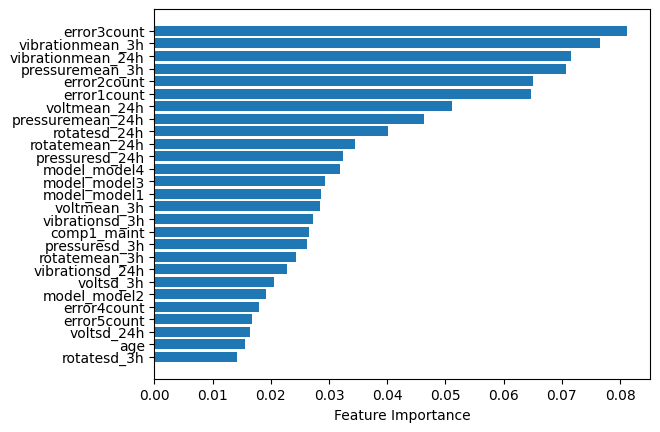


--------------------------------  component 2  ---------------------------------------
2
POISSON Regression 2
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp2_maint', 'comp2_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 5230865.0
[100] ELBO: 4220656.7
[200] ELBO: 3249508.7
[300] ELBO: 4785540.1
[400] ELBO: 3257101.3
[500] ELBO: 5149075.3
[600] ELBO: 3422104.6
[700] ELBO: 2788865.9
[800] ELBO: 2640334.7
[900] ELBO: 2573947.8


/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.045
MAE: 27.919
RMSE: 42.394
R2: 0.000


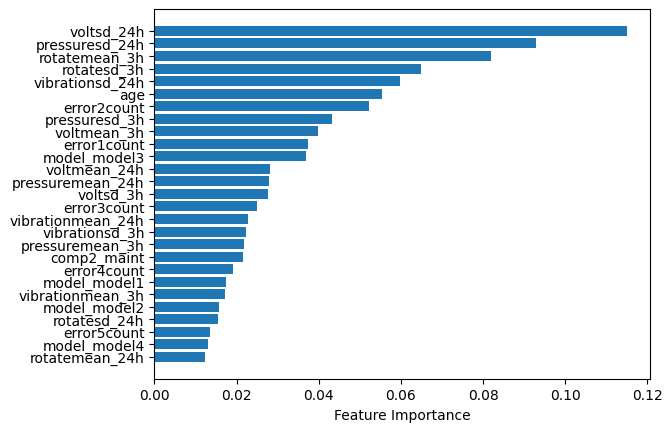


--------------------------------  component 3  ---------------------------------------
3
POISSON Regression 3
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp3_maint', 'comp3_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 1714734.0
[100] ELBO: 1612391.9
[200] ELBO: 1801373.7
[300] ELBO: 1593593.4
[400] ELBO: 1100147.8
[500] ELBO: 1536780.1
[600] ELBO: 1961179.6
[700] ELBO: 1463927.2
[800] ELBO: 1130452.4
[900] ELBO: 1319702.9


/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.001
MAE: 39.621
RMSE: 59.540
R2: 0.000


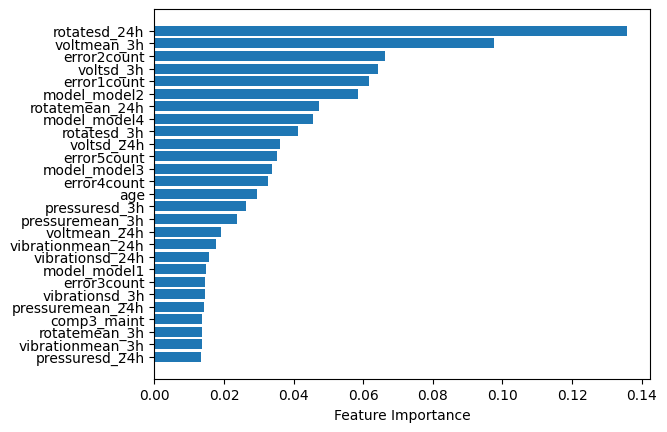


--------------------------------  component 4  ---------------------------------------
4
POISSON Regression 4
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp4_maint', 'comp4_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 2971632.2
[100] ELBO: 2507988.6
[200] ELBO: 1829514.0
[300] ELBO: 1317206.3
[400] ELBO: 1903668.9
[500] ELBO: 1198735.8
[600] ELBO: 1589704.5
[700] ELBO: 1454534.7
[800] ELBO: 1550457.2
[900] ELBO: 1347545.7


/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: -0.032
MAE: 52.559
RMSE: 84.320
R2: 0.000


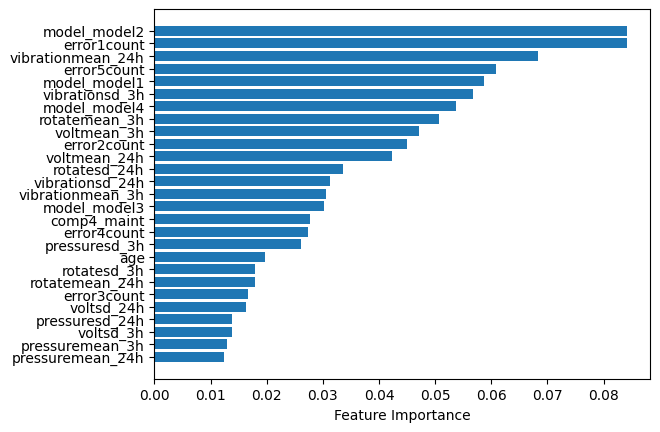

In [18]:
poisson_results = {"poisson": {'comp_1':  {'MAE':0, 'FI':''}, 'comp_2':  {'MAE':0, 'FI':''}, 'comp_3':  {'MAE':0, 'FI':''}, 'comp_4':  {'MAE':0, 'FI':''}}}

for comp_number in range(1,5):
    print(f"\n--------------------------------  component {comp_number}  ---------------------------------------")
    svi_regression = SVI_regression_model(labeled_features, comp_number)
    svi_dataset = svi_regression.get_data_for_component()
    poisson = SVI_model_format.poisson 
    
    y_poisson, X_poisson, X_train_torch_poisson, y_train_torch_poisson, X_test_torch_poisson, X_test_poisson, y_test_poisson, X_train_poisson, y_train_poisson, y_std_poisson, y_mean_poisson = svi_regression.Preprocess(X_init=svi_dataset, model=poisson['name'])
    poisson_guide = svi_regression.pyro_inference(X_train_torch=X_train_torch_poisson, y_train_torch=y_train_torch_poisson, model=poisson['model'], steps=5000)
    poisson_preds, poisson_y_true, poisson_features_importance = svi_regression.post_process(guide=poisson_guide, model=poisson, X_train_torch=X_train_torch_poisson, y_train_torch=y_train_torch_poisson, X_test=X_test_poisson, y_test=y_test_poisson, y_std=y_std_poisson, y_mean=y_mean_poisson)
    
    poisson_results = results(svi_dataset, poisson_features_importance, poisson_results, 'poisson', comp_number, poisson_y_true, poisson_preds)

In [20]:
poisson_results

{'poisson': {'comp_1': {'MAE': 51.75913781792672, 'FI': 'error3count'},
  'comp_2': {'MAE': 27.919317555119246, 'FI': 'voltsd_24h'},
  'comp_3': {'MAE': 39.62114483593811, 'FI': 'rotatesd_24h'},
  'comp_4': {'MAE': 52.55877631149146, 'FI': 'model_model2'}}}

#### Heteorscedastic


--------------------------------  component 1  ---------------------------------------
1
HETEROSCEDASTIC Regression 1
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1_maint', 'comp1_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 423431110.7
[100] ELBO: 1084701676.0
[200] ELBO: 72997178.0
[300] ELBO: 18734541.0
[400] ELBO: 11216739.7
[500] ELBO: 17430956.6
[600] ELBO: 22619467.6
[700] ELBO: 188681605.1
[800] ELBO: 8631638.5
[900] ELBO: 16015983.5
[1000] ELBO: 6077284.8
[1100] ELBO: 12184

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.216
MAE: 41.957
RMSE: 63.720
R2: 0.000


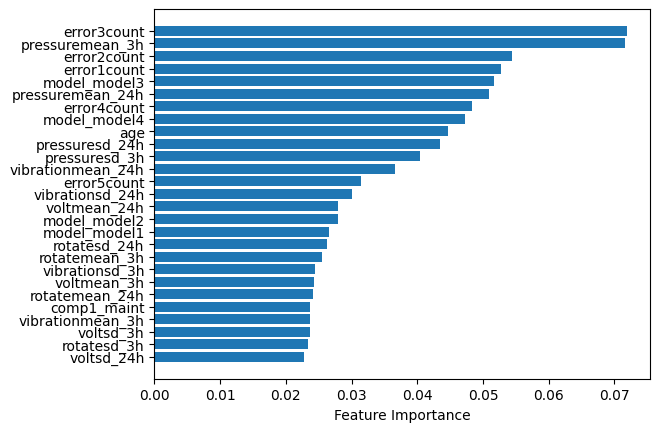


--------------------------------  component 2  ---------------------------------------
2
HETEROSCEDASTIC Regression 2
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp2_maint', 'comp2_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 274527046.8
[100] ELBO: 171281127.1
[200] ELBO: 265244493.8
[300] ELBO: 69803839.7
[400] ELBO: 50931358.1
[500] ELBO: 101448648.0
[600] ELBO: 153665033.2
[700] ELBO: 55430610.1
[800] ELBO: 96029257.3
[900] ELBO: 45216360.7
[1000] ELBO: 39713493.2
[1100] ELBO: 61

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.033
MAE: 34.113
RMSE: 40.435
R2: 0.000


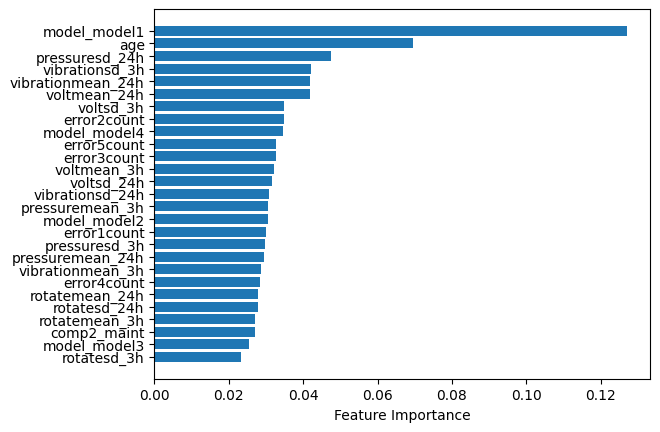


--------------------------------  component 3  ---------------------------------------
3
HETEROSCEDASTIC Regression 3
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp3_maint', 'comp3_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 698842401.4
[100] ELBO: 496482627.2
[200] ELBO: 1274279012.4
[300] ELBO: 482941006.0
[400] ELBO: 117051565.0
[500] ELBO: 148703213.7
[600] ELBO: 152930846.2
[700] ELBO: 105451704.0
[800] ELBO: 71024054.5
[900] ELBO: 47808669.4
[1000] ELBO: 67788884.8
[1100] ELBO

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.065
MAE: 31.525
RMSE: 47.975
R2: 0.000


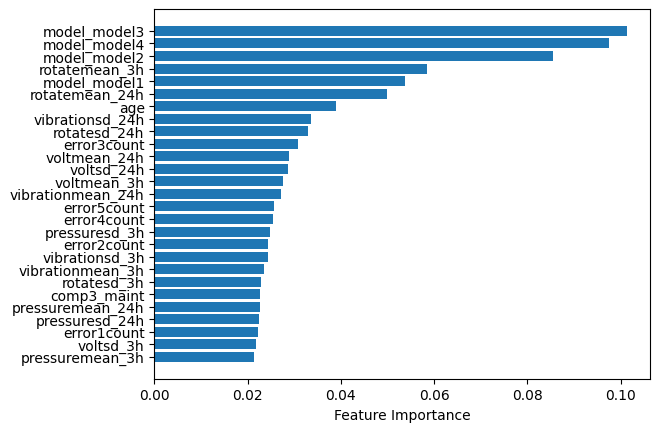


--------------------------------  component 4  ---------------------------------------
4
HETEROSCEDASTIC Regression 4
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp4_maint', 'comp4_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 893781226.7
[100] ELBO: 6110632558.8
[200] ELBO: 4118542192.3
[300] ELBO: 407369962.7
[400] ELBO: 142980835.5
[500] ELBO: 1038804128.5
[600] ELBO: 287165578.6
[700] ELBO: 165650708.6
[800] ELBO: 296105516.7
[900] ELBO: 84636887.7
[1000] ELBO: 39605079.7
[1100] E

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.080
MAE: 49.613
RMSE: 68.732
R2: 0.000


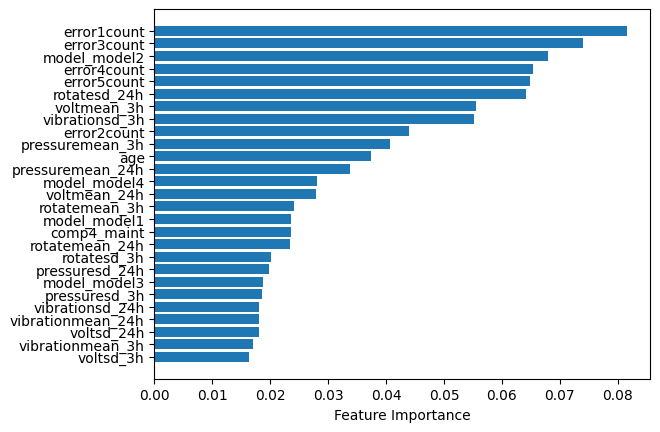

In [21]:
hetero_results = {'hetero': {'comp_1':  {'MAE':0, 'FI':''}, 'comp_2':  {'MAE':0, 'FI':''}, 'comp_3':  {'MAE':0, 'FI':''}, 'comp_4':  {'MAE':0, 'FI':''}}}

for comp_number in range(1,5):
    
    print(f"\n--------------------------------  component {comp_number}  ---------------------------------------")
    svi_regression = SVI_regression_model(labeled_features, comp_number)
    svi_dataset = svi_regression.get_data_for_component()
    hetero = SVI_model_format.heterosc
    
    y_hetero, X_hetero, X_train_torch_hetero, y_train_torch_hetero, X_test_torch_hetero, X_test_hetero, y_test_hetero, X_train_hetero, y_train_hetero, y_std_hetero, y_mean_hetero = svi_regression.Preprocess(X_init=svi_dataset, model=hetero['name'])
    hetero_guide = svi_regression.pyro_inference(X_train_torch=X_train_torch_hetero, y_train_torch=y_train_torch_hetero, model=hetero['model'], steps=5000)
    hetero_preds, hetero_y_true, hetero_features_importance = svi_regression.post_process(guide=hetero_guide, model=hetero, X_train_torch=X_train_torch_hetero, y_train_torch=y_train_torch_hetero, X_test=X_test_hetero, y_test=y_test_hetero, y_std=y_std_hetero, y_mean=y_mean_hetero)

    hetero_results = results(svi_dataset, hetero_features_importance, hetero_results, 'hetero', comp_number, hetero_y_true, hetero_preds)    

In [22]:
hetero_results

{'hetero': {'comp_1': {'MAE': 41.95669489818681, 'FI': 'error3count'},
  'comp_2': {'MAE': 34.112791229185206, 'FI': 'model_model1'},
  'comp_3': {'MAE': 31.525359212048837, 'FI': 'model_model3'},
  'comp_4': {'MAE': 49.61256645471692, 'FI': 'error1count'}}}

#### Linear


--------------------------------  component 1  ---------------------------------------
1
LINEAR Regression 1
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1_maint', 'comp1_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 1982862.7
[100] ELBO: 2066612.9
[200] ELBO: 1964548.4
[300] ELBO: 1930806.8
[400] ELBO: 1970945.9
[500] ELBO: 1981582.3
[600] ELBO: 1908780.2
[700] ELBO: 2025525.0
[800] ELBO: 1940484.8
[900] ELBO: 1995248.9
[1000] ELBO: 2040106.1
[1100] ELBO: 1990702.8
[1200] ELBO: 1746

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.246
MAE: 68.088
RMSE: 78.939
R2: 0.000


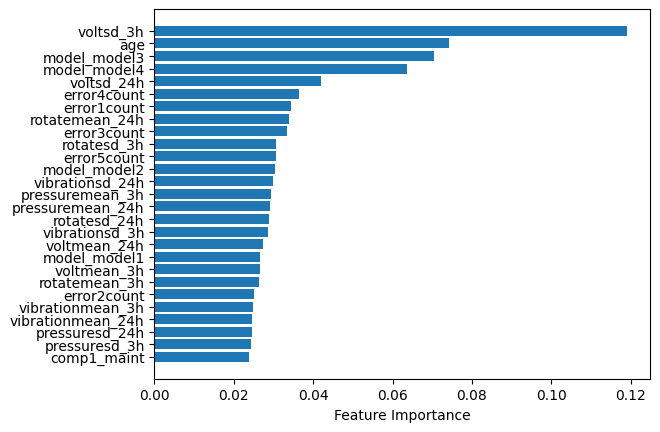


--------------------------------  component 2  ---------------------------------------
2
LINEAR Regression 2
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp2_maint', 'comp2_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 3107228.1
[100] ELBO: 3055131.2
[200] ELBO: 2878162.6
[300] ELBO: 2993045.2
[400] ELBO: 2903121.4
[500] ELBO: 2955859.4
[600] ELBO: 2973418.0
[700] ELBO: 2862536.1
[800] ELBO: 2968843.2
[900] ELBO: 2765646.0
[1000] ELBO: 2850054.8
[1100] ELBO: 2876931.6
[1200] ELBO: 2882

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.034
MAE: 64.138
RMSE: 70.958
R2: 0.000


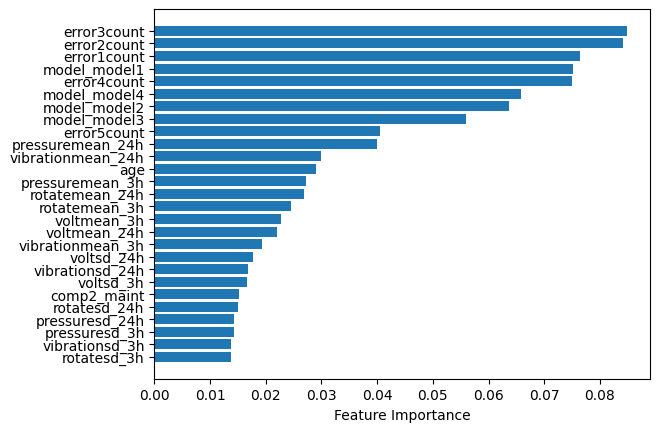


--------------------------------  component 3  ---------------------------------------
3
LINEAR Regression 3
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp3_maint', 'comp3_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 1991003.9
[100] ELBO: 2092620.7
[200] ELBO: 1890471.3
[300] ELBO: 1994579.7
[400] ELBO: 1942557.7
[500] ELBO: 1946942.7
[600] ELBO: 2105235.5
[700] ELBO: 1955210.6
[800] ELBO: 1857273.6
[900] ELBO: 1942022.8
[1000] ELBO: 1838264.9
[1100] ELBO: 2057393.0
[1200] ELBO: 1882

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.105
MAE: 51.014
RMSE: 58.586
R2: 0.000


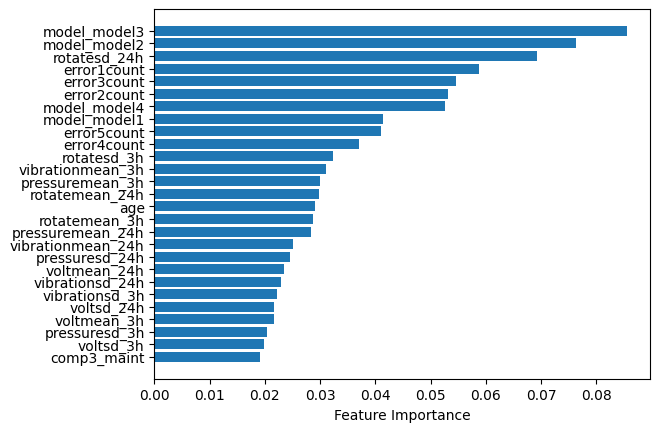


--------------------------------  component 4  ---------------------------------------
4
LINEAR Regression 4
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp4_maint', 'comp4_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 1940789.5
[100] ELBO: 1974478.4
[200] ELBO: 1910731.3
[300] ELBO: 2001216.2
[400] ELBO: 1870281.3
[500] ELBO: 1907180.1
[600] ELBO: 2072442.5
[700] ELBO: 1943765.4
[800] ELBO: 1899971.7
[900] ELBO: 1850010.4
[1000] ELBO: 1813804.6
[1100] ELBO: 1997797.0
[1200] ELBO: 1905

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.095
MAE: 60.876
RMSE: 71.838
R2: 0.000


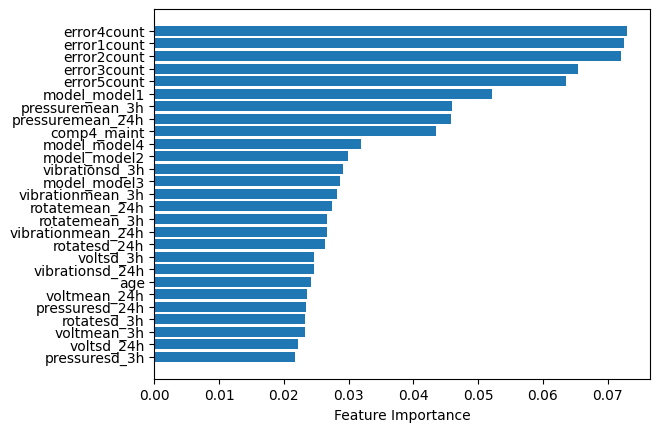

In [23]:
linear_svi_results = {'linear_svi': {'comp_1':  {'MAE':0, 'FI':''}, 'comp_2':  {'MAE':0, 'FI':''}, 'comp_3':  {'MAE':0, 'FI':''}, 'comp_4':  {'MAE':0, 'FI':''}}}

for comp_number in range(1,5):
    
    print(f"\n--------------------------------  component {comp_number}  ---------------------------------------")
    svi_regression = SVI_regression_model(labeled_features, comp_number)
    svi_dataset = svi_regression.get_data_for_component()
    linear_svi = SVI_model_format.linear
 
    y_linear_svi, X_linear_svi, X_train_torch_linear_svi, y_train_torch_linear_svi,  X_test_torch_linear_svi, X_test_linear_svi, y_test_linear_svi, X_train_linear_svi, y_train_linear_svi, y_std_linear_svi, y_mean_linear_svi = svi_regression.Preprocess(X_init=svi_dataset, model=linear_svi['name'])
    linear_svi_guide = svi_regression.pyro_inference(X_train_torch=X_train_torch_linear_svi, y_train_torch=y_train_torch_linear_svi, model=linear_svi['model'], steps=5000)
    linear_svi_preds, linear_svi_y_true, linear_features_importance = svi_regression.post_process(guide=linear_svi_guide, model=linear_svi, X_train_torch=X_train_torch_linear_svi, y_train_torch=y_train_torch_linear_svi, X_test=X_test_linear_svi, y_test=y_test_linear_svi, y_std=y_std_linear_svi, y_mean=y_mean_linear_svi)
    
    linear_svi_results = results(svi_dataset, linear_features_importance, linear_svi_results, 'linear_svi', comp_number, linear_svi_y_true, linear_svi_preds)    

In [24]:
linear_svi_results

{'linear_svi': {'comp_1': {'MAE': 68.08780953573331, 'FI': 'voltsd_3h'},
  'comp_2': {'MAE': 64.13840077348989, 'FI': 'error3count'},
  'comp_3': {'MAE': 51.01430112496538, 'FI': 'model_model3'},
  'comp_4': {'MAE': 60.875975851247794, 'FI': 'error4count'}}}

### MCMC

In [ ]:
class MCMC_model_format():
    '''
    defining the type of the regression
    '''
    poisson = {'name':"POISSON", 'model':poisson_model}
    heterosc = {'name':"HETEROSCEDASTIC", 'model':heteroscedastic_model}
    linear = {'name':"LINEAR", 'model':linear_model}

class MCMC_regression_model():

    def __init__(self, data: pd.DataFrame, component: int) -> None:
        
        self.data = data
        self.component = component
        print(self.component)

    def get_data_for_component(self) -> pd.DataFrame:
        
        '''
        returns the feautures of the dataset and the component we want to predict for
        '''
    
        components_cols = ['comp1_maint', 'comp2_maint', 'comp3_maint', 'comp4_maint',
       'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4',
       'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life']
        
        cols = ['machineID', 'voltmean_3h', 'rotatemean_3h',
                'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
                'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
                'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
                'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
                'error3count', 'error4count', 'error5count','age',
                'model_model1', 'model_model2', 'model_model3', 'model_model4'] + [word for word in components_cols if str(self.component) in ([*word]) and 'failure' not in word.split('_')]


        return self.data[cols]
    
    def Preprocess(self, X_init: pd.DataFrame, model: str) -> \
        Tuple[np.ndarray, np.ndarray,  torch.tensor,  torch.tensor, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.float64, np.float64]:

        '''
        the necessary data preprocess before procceding in pyro inference
        '''
        print(f"{model} Regression {self.component}")
        print(X_init.columns)
        print('\n-----------------------------------------------------------------------')

        y, X, X_train_torch, y_train_torch, X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean = preprocess(X_init,0.1,model,classi=False,splitting=True)
 
        return y, X, X_train_torch, y_train_torch, X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean
    

    def pyro_inference(self, X_train_torch, y_train_torch, model, num_samples):

        # Reset parameter values
        pyro.clear_param_store()

        # Run inference in Pyro
        nuts_kernel = NUTS(model)
        
        mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=200, num_chains=1)
        mcmc.run(X_train_torch, y_train_torch)
        
        # Compute feature importance
        feature_names = self.data.columns[1:-1]
        print(feature_names)
        
        feature_importance = {}

        for feature in feature_names:
            marginal = EmpiricalMarginal(mcmc.get_samples(), sites=feature)
            feature_importance[feature] = torch.std(marginal._get_samples_and_weights()[0]).item()

        print("Feature Importance:")
        for feature, importance in feature_importance.items():
            print(f"{feature}: {importance}")

        # Show summary of inference results
        print(mcmc.summary())

        return mcmc.get_samples()

    def post_process(self, X_test, X_train, samples, y_std, y_mean, y_test):

        posterior_samples = samples

        # Compute predictions
        y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)
        y_hat_train = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_train, posterior_samples["beta"].numpy().T), axis=1)

        # Convert back to the original scale
        preds = y_hat * y_std + y_mean
        preds_train = y_hat_train * y_std + y_mean
        y_true = y_test * y_std + y_mean

        return preds, y_true

In [ ]:
linear_mcmc_results = {'linear_mcmc': {'comp_1': 0, 'comp_2':0, 'comp_3': 0, 'comp_4':0}}

In [ ]:
for comp_number in range(1,5):
    print(f"\n--------------------------------  component {comp_number}  ---------------------------------------")
    mcmc_regression = MCMC_regression_model(labeled_features, comp_number)
    mcmc_dataset = mcmc_regression.get_data_for_component()
    linear_mcmc = MCMC_model_format.linear
 

    y_linear_mcmc, X_linear_mcmc, X_train_torch_linear_mcmc, y_train_torch_linear_mcmc,  X_test_torch_linear_mcmc, X_test_linear_mcmc, y_test_linear_mcmc, X_train_linear_mcmc, y_train_linear_mcmc, y_std_linear_mcmc, y_mean_linear_mcmc = mcmc_regression.Preprocess(X_init=mcmc_dataset, model=linear_mcmc['name'])
  
    linear_mcmc_samples = mcmc_regression.pyro_inference(X_train_torch=X_train_torch_linear_mcmc, y_train_torch=y_train_torch_linear_mcmc, model=linear_mcmc['model'], num_samples=100)
    linear_mcmc_preds, linear_mcmc_y_true = mcmc_regression.post_process(samples=linear_mcmc_samples, X_train = X_train_linear_mcmc, X_test = X_test_linear_mcmc, y_test=y_test_linear_mcmc, y_std=y_std_linear_mcmc, y_mean=y_mean_linear_mcmc)
    
    corr_linear_mcmc, mae_linear_mcmc, rae_linear_mcmc, rmse_linear_mcmc, r2_linear_mcmc, mcmc_trues_linear_mcmc, mcmc_pred_linear_mcmc = compute_error(trues=linear_mcmc_y_true, predicted=linear_mcmc_preds, threshold=None)
    linear_mcmc_results['linear_mcmc'][f"comp_{comp_number}"] = [mae_linear_mcmc]
    print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr_linear_mcmc, mae_linear_mcmc, rmse_linear_mcmc, r2_linear_mcmc))
    print('\n')

### NEURAL NETWORKS

In [ ]:
class ModelFormat():
    '''
    defining the type of the regression
    '''
    neural_netwrok = {'name':'NN'}
    poisson = {'name':"POISSON", 'model':poisson_model}
    heterosc = {'name':"HETEROSCEDASTIC", 'model':heteroscedastic_model}
    linear = {'name':"LINEAR", 'model':linear_model}

class FFNN(PyroModule):
    def __init__(self, n_in, n_hidden, n_out, type_forward):
        
        self.type_forward = type_forward
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_in]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.h_layer = PyroModule[nn.Linear](n_hidden, n_hidden)
        self.h_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden, n_hidden]).to_event(2))

        self.out_layer = PyroModule[nn.Linear](n_hidden, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden]).to_event(2))

        # Activation functions
        self.tanh = nn.Tanh()
        
    def forward(self, X, y=None):
        
        if self.type_forward == 'simple':
            X = self.tanh(self.in_layer(X))
            X = self.tanh(self.h_layer(X))
            X = self.out_layer(X)
            prediction_mean = X.squeeze(-1)
            with pyro.plate("observations"):
                y = pyro.sample("obs", dist.Normal(prediction_mean, 0.1), obs=y)
        
        elif self.type_forward == 'interpretable':
            X_nn = X[:,1:]
            X_nn = self.tanh(self.in_layer(X_nn))
            X_nn = self.tanh(self.h_layer(X_nn))
            X_nn = self.out_layer(X_nn)
            nn_out = X_nn.squeeze(-1)

            beta_lin = pyro.sample("beta", dist.Normal(0, 1))
            X_linear = X[:,0]
            with pyro.plate("observations"):
                linear_out = X_linear*beta_lin
                y = pyro.sample("obs", dist.Normal(nn_out+linear_out, 0.1), obs=y)

        return y

def train_nn(model0, X_train_torch, y_train_torch):
    
    if model0 =="simple":
        model = FFNN(n_in=X_train_torch.shape[1], n_hidden=32, n_out=1, type_forward=model0)
        
    elif model0 == "interpretable":
        model = FFNN(n_in=X_train_torch.shape[1]-1, n_hidden=32, n_out=1, type_forward=model0)
        
    guide = AutoDiagonalNormal(model)
    pyro.clear_param_store()
    # Define the number of optimization steps
    n_steps = 1000#10000 kanonika!

    # Setup the optimizer
    adam_params = {"lr": 0.01}
    optimizer = Adam(adam_params)

    # Setup the inference algorithm
    elbo = Trace_ELBO(num_particles=1)
    svi = SVI(model, guide, optimizer, loss=elbo)

    # Do gradient steps
    for step in range(n_steps):
        elbo = svi.step(X_train_torch,y_train_torch)
        if step % 500 == 0:
            print("[%d] ELBO: %.1f" % (step, elbo))
    
    return model, guide

def get_data_for_component(data, component) -> pd.DataFrame:
        
    '''
    returns the feautures of the dataset and the component we want to predict for
    '''
    
    components_cols = ['comp1_maint', 'comp2_maint', 'comp3_maint', 'comp4_maint',
                       'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4',
                       'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life']
        
    cols = ['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h', 'vibrationmean_3h',
            'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h',
            'rotatemean_24h', 'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
            'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
            'error4count', 'error5count','age', 'model_model1', 'model_model2',
            'model_model3', 'model_model4'] + [word for word in components_cols if str(component) in ([*word]) and 'failure' not in word.split('_')]


    return data[cols]

def test_nn(model,guide,X_test_torch):
    
    # Predict
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000,return_sites=("obs", "_RETURN"))
    samples = predictive(X_test_torch)
    y_pred = samples["obs"].mean(axis=0).detach().numpy()
    
    y_preds = y_pred * y_std + y_mean
    y_true = y_test * y_std + y_mean
    
    return y_preds, y_true

def test_nn_beta(model,guide,X_test_torch):
    # Predict
    predictive = pyro.infer.Predictive(model, guide=guide, num_samples=1000,return_sites=("beta",))
    samples = predictive(X_test_torch)
    print("Estimated beta:", samples["beta"].mean(axis=0).detach().numpy())

def mae_test(y_pred, y_test):

    mae = np.mean(np.abs(y_pred - y_test))
    print("MAE:", mae)
    
    return mae

def plot_pred(y_pred,y_test,y_std,y_mean,threshold,start=None,end=None):
    fig = plt.figure(figsize=(20, 10))

    start = start
    end = end
    y_true = y_test * y_std + y_mean
    y_pre = y_pred * y_std + y_mean

    plt.plot(y_true[y_pre>threshold], 'r.-', label='test')
    plt.plot(y_pre[y_pre>threshold], 'b-', label='pred')
    plt.legend()
    plt.show()
    
    return y_true,y_pre

In [ ]:
for comp_number in range(3,5):

    print(f"\n--------------------------------  component {comp_number}  ---------------------------------------")
    nn_dataset = get_data_for_component(labeled_features, comp_number)
    y, X, X_train_torch, y_train_torch,X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean = preprocess(nn_dataset, 0.1, 'neural_network')
    model_FFNN, guide = train_nn("simple", X_train_torch, y_train_torch)
    y_preds, y_true = test_nn(model_FFNN, guide, X_test_torch)
#   corr, mae, rae, rmse, r2, trues, predicted=compute_error(y_pred,y_test, y_std, y_mean, False)
#   print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))
    mae = mae_test(y_preds, y_true)
    print('\n')   

### Data Threshold

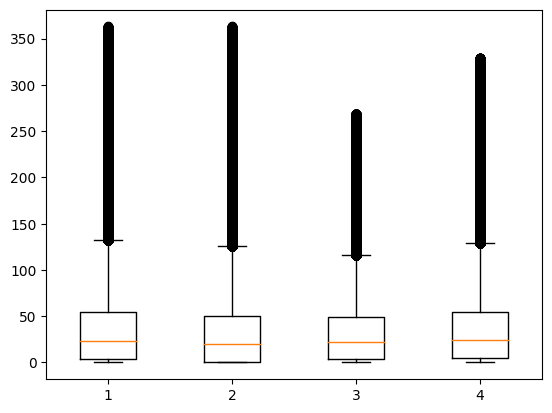

In [30]:
plt.boxplot(labeled_features[["comp1_life","comp2_life","comp3_life","comp4_life"]])
plt.show()


--------------------------------  component 1  ---------------------------------------
(504037, 44)
1
POISSON Regression 1
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1_maint', 'comp1_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 10696298.2
[100] ELBO: 3917139.5
[200] ELBO: 5277715.2
[300] ELBO: 5812397.1
[400] ELBO: 3665561.8
[500] ELBO: 3578734.9
[600] ELBO: 3300152.5
[700] ELBO: 3665916.6
[800] ELBO: 3176678.3
[900] ELBO: 3200556.4
[1000] ELBO: 2319594.5
[1100] ELBO: 2179310.6
[1

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: -0.040
MAE: 10.583
RMSE: 13.800
R2: 0.000


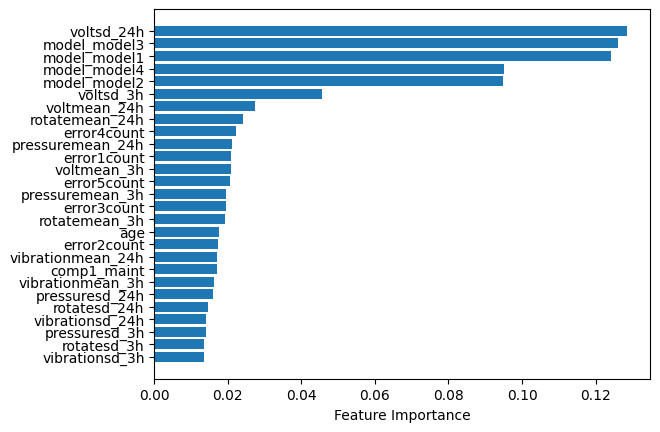


--------------------------------  component 2  ---------------------------------------
(523309, 44)
2
POISSON Regression 2
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp2_maint', 'comp2_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 1436476.9
[100] ELBO: 1013150.6
[200] ELBO: 1174483.1
[300] ELBO: 1131188.3
[400] ELBO: 1104162.2
[500] ELBO: 1275779.9
[600] ELBO: 786818.7
[700] ELBO: 724649.6
[800] ELBO: 634545.0
[900] ELBO: 714501.9
[1000] ELBO: 1042408.6
[1100] ELBO: 765857.8
[1200] E

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: 0.253
MAE: 7.734
RMSE: 11.910
R2: 0.000


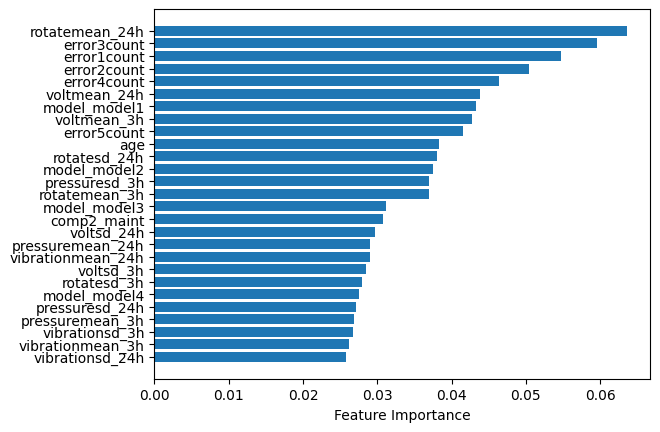


--------------------------------  component 3  ---------------------------------------
(522654, 44)
3
POISSON Regression 3
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp3_maint', 'comp3_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 1957010.4
[100] ELBO: 1547798.8
[200] ELBO: 1528714.6
[300] ELBO: 1147437.0
[400] ELBO: 1230629.2
[500] ELBO: 1314124.5
[600] ELBO: 1100649.6
[700] ELBO: 1374993.9
[800] ELBO: 1355140.6
[900] ELBO: 1059332.1
[1000] ELBO: 1133332.8
[1100] ELBO: 963593.4
[120

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: -0.017
MAE: 11.038
RMSE: 14.387
R2: 0.000


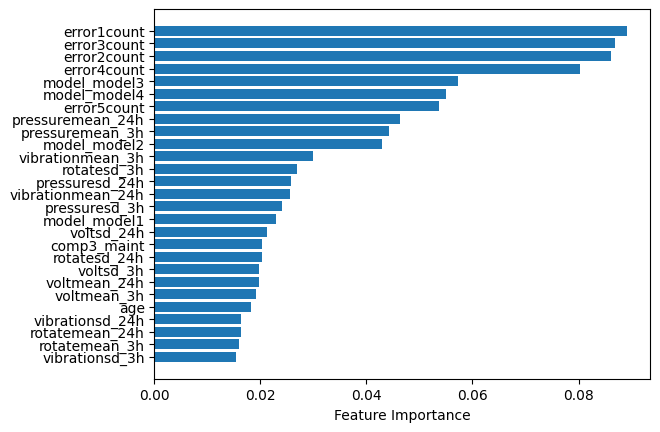


--------------------------------  component 4  ---------------------------------------
(493101, 44)
4
POISSON Regression 4
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp4_maint', 'comp4_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 1287510.6
[100] ELBO: 1316195.0
[200] ELBO: 1171574.9
[300] ELBO: 1131382.0
[400] ELBO: 824476.1
[500] ELBO: 716866.2
[600] ELBO: 793390.2
[700] ELBO: 809540.0
[800] ELBO: 876426.2
[900] ELBO: 661961.0
[1000] ELBO: 771314.1
[1100] ELBO: 635315.9
[1200] ELBO

/tmp/ipykernel_344927/3339535372.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/3339535372.py:130: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/3339535372.py:133: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


No threshold
CorrCoef: -0.034
MAE: 9.942
RMSE: 13.584
R2: 0.000


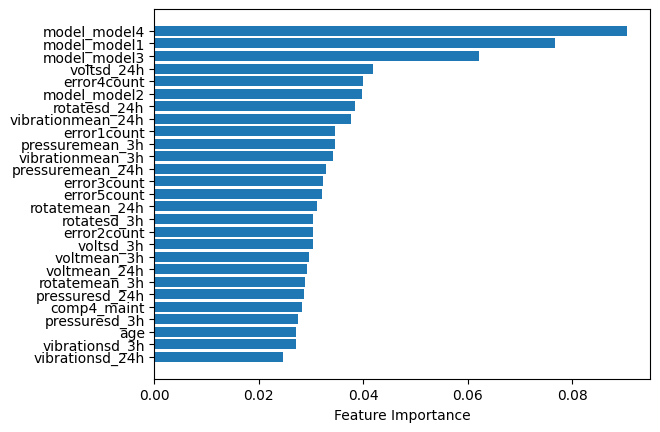

In [33]:
poisson_results = {"poisson": {'comp_1':  {'MAE':0, 'FI':''}, 'comp_2':  {'MAE':0, 'FI':''}, 'comp_3':  {'MAE':0, 'FI':''}, 'comp_4':  {'MAE':0, 'FI':''}}}

for comp_number in range(1,5):
    print(f"\n--------------------------------  component {comp_number}  ---------------------------------------")
    data = labeled_features[labeled_features[f"comp{comp_number}_life"]<=30]
    print(data.shape)
    svi_regression = SVI_regression_model(data, comp_number)
    svi_dataset = svi_regression.get_data_for_component()
    poisson = SVI_model_format.poisson 
    
    y_poisson, X_poisson, X_train_torch_poisson, y_train_torch_poisson, X_test_torch_poisson, X_test_poisson, y_test_poisson, X_train_poisson, y_train_poisson, y_std_poisson, y_mean_poisson = svi_regression.Preprocess(X_init=svi_dataset, model=poisson['name'])
    poisson_guide = svi_regression.pyro_inference(X_train_torch=X_train_torch_poisson, y_train_torch=y_train_torch_poisson, model=poisson['model'], steps=5000)
    poisson_preds, poisson_y_true, poisson_features_importance = svi_regression.post_process(guide=poisson_guide, model=poisson, X_train_torch=X_train_torch_poisson, y_train_torch=y_train_torch_poisson, X_test=X_test_poisson, y_test=y_test_poisson, y_std=y_std_poisson, y_mean=y_mean_poisson)
    
    poisson_results = results(svi_dataset, poisson_features_importance, poisson_results, 'poisson', comp_number, poisson_y_true, poisson_preds)

In [40]:
poisson_results

{'poisson': {'comp_1': {'MAE': 51.01794971759683, 'FI': 'vibrationmean_24h'},
  'comp_2': {'MAE': 28.0718595361325, 'FI': 'model_model3'},
  'comp_3': {'MAE': 0, 'FI': ''},
  'comp_4': {'MAE': 0, 'FI': ''}}}


--------------------------------  component 1  ---------------------------------------
1
POISSON Regression 1
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp1_maint', 'comp1_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 2923319.4
[100] ELBO: 2035898.4
[200] ELBO: 1944222.3
[300] ELBO: 2237630.8
[400] ELBO: 2155182.4
[500] ELBO: 1514528.5
[600] ELBO: 1844210.0
[700] ELBO: 1819319.3
[800] ELBO: 1603991.6
[900] ELBO: 1646740.9
30
CorrCoef: 0.045
MAE: 50.364
RMSE: 79.326
R2: 0.000


/tmp/ipykernel_344927/1315644456.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop(columns='machineID', inplace=True, axis=1)
/tmp/ipykernel_344927/1315644456.py:131: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  feautures_dict = dict(zip(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0]))
/tmp/ipykernel_344927/1315644456.py:134: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  plt.barh(dataset.columns[sort].tolist()[0], features_importance[0][sort].tolist()[0])


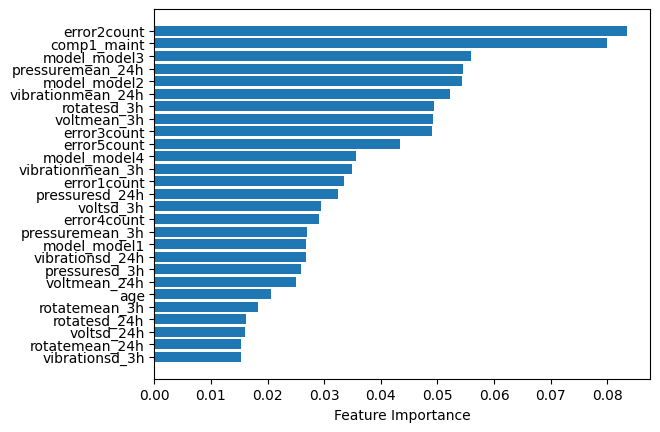


--------------------------------  component 2  ---------------------------------------
2
POISSON Regression 2
Index(['machineID', 'voltmean_3h', 'rotatemean_3h', 'pressuremean_3h',
       'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h', 'pressuresd_3h',
       'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h', 'pressuresd_24h',
       'vibrationsd_24h', 'error1count', 'error2count', 'error3count',
       'error4count', 'error5count', 'age', 'model_model1', 'model_model2',
       'model_model3', 'model_model4', 'comp2_maint', 'comp2_life'],
      dtype='object')

-----------------------------------------------------------------------
[0] ELBO: 6476704.4
[100] ELBO: 3752902.6
[200] ELBO: 4717820.5
[300] ELBO: 5937065.6
[400] ELBO: 3190042.6
[500] ELBO: 2052198.2


KeyboardInterrupt: 

In [41]:
poisson_results = {"poisson": {'comp_1':  {'MAE':0, 'FI':''}, 'comp_2':  {'MAE':0, 'FI':''}, 'comp_3':  {'MAE':0, 'FI':''}, 'comp_4':  {'MAE':0, 'FI':''}}}

for comp_number in range(1,5):
    print(f"\n--------------------------------  component {comp_number}  ---------------------------------------")
    svi_regression = SVI_regression_model(labeled_features, comp_number)
    svi_dataset = svi_regression.get_data_for_component()
    poisson = SVI_model_format.poisson 
    
    y_poisson, X_poisson, X_train_torch_poisson, y_train_torch_poisson, X_test_torch_poisson, X_test_poisson, y_test_poisson, X_train_poisson, y_train_poisson, y_std_poisson, y_mean_poisson = svi_regression.Preprocess(X_init=svi_dataset, model=poisson['name'])
    poisson_guide = svi_regression.pyro_inference(X_train_torch=X_train_torch_poisson, y_train_torch=y_train_torch_poisson, model=poisson['model'], steps=1000)
    poisson_preds, poisson_y_true, poisson_features_importance = svi_regression.post_process(guide=poisson_guide, model=poisson, X_train_torch=X_train_torch_poisson, y_train_torch=y_train_torch_poisson, X_test=X_test_poisson, y_test=y_test_poisson, y_std=y_std_poisson, y_mean=y_mean_poisson)
    
    poisson_results = results(svi_dataset, poisson_features_importance, poisson_results, 'poisson', comp_number, poisson_y_true, poisson_preds, threshold=30)